In [13]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import os
import pickle
import lzma
import torch
from metadrive import MetaDriveEnv
from concurrent.futures import ProcessPoolExecutor
from env import State, Observation, Action, next_state, normalize_angle, get_metadrive_state, state_batch_to_tensor, action_batch_to_tensor
from metadrive_model import MetadriveModel, metadrive_model_train_batch
from model_utils import set_lr
from torch.utils.data import TensorDataset, DataLoader
import itertools
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def generate_2d_velocity(v:float) -> np.ndarray:
    """
    Generates a random 2D velocity vector with a magnitude between 0 and v
    """
    mag = np.random.uniform(0, v)
    heading = np.random.uniform(-np.pi, np.pi)
    return np.array([mag * np.cos(heading), mag * np.sin(heading)])

def gen_random_state_action() -> tuple[State, Action]:
    """
    Generates a random state with probabilities that are similar to that are found in the waymo dataset
    """
    if np.random.rand() < 0.5:
        # parked 
        vel = generate_2d_velocity(1)
        heading = np.random.uniform(-np.pi, np.pi)
        action = np.random.uniform(-1, 1), np.random.normal(0, 0.1)
    else:
        # moving
        vel = generate_2d_velocity(35)
        heading = normalize_angle(np.arctan2(vel[1], vel[0]) + np.random.normal(0, 0.2))
        action = np.random.normal(0, 0.3), np.random.normal(0.2, 0.3)

    return State(heading=heading, velocity=vel), action

def generate_data(n: int) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for _ in range(n):
        s0, a = gen_random_state_action()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [3]:
NUM_SCENARIOS = 500_000
MAX_WORKERS = 16

mm_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(NUM_SCENARIOS, MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    for i in range(leftover_size):
        n_scenarios_per_worker[i] += 1

    # Generate the data in parallel
    for batch in executor.map(generate_data, n_scenarios_per_worker):
        mm_data.extend(batch)

[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Senso

In [23]:
# save data
if not os.path.exists("./data/mm_data.pkl.xz"):
    with lzma.open("./data/mm_data.pkl.xz", "wb") as f:
        pickle.dump(mm_data, f)

In [4]:
# load data
if not "mm_data" in locals():
    with lzma.open("./data/mm_data.pkl.xz", "rb") as f:
        mm_data: list[tuple[State, Action, State]] = pickle.load(f)

In [7]:
# 90:10 train-validation split
random.seed(0)
random.shuffle(mm_data)
mm_train_data = mm_data[:int(len(mm_data)*0.9)]
mm_validation_data = mm_data[int(len(mm_data)*0.9):]

In [25]:
print("train data size:", len(mm_train_data))
print("validation data size:", len(mm_validation_data))

train data size: 450000
validation data size: 50000


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
mm_train_dataset = TensorDataset(
    state_batch_to_tensor([s0 for s0, _, _ in mm_train_data], torch.device("cpu")),
    action_batch_to_tensor([a for _, a, _ in mm_train_data], torch.device("cpu")),
    state_batch_to_tensor([s1 for _, _, s1 in mm_train_data], torch.device("cpu"))
)
mm_train_loader = DataLoader(mm_train_dataset, batch_size=8192)
mm_train_iter = itertools.cycle(iter(mm_train_loader))

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.AdamW(mm.parameters())

mm_step = 0
mm_losses = []

In [28]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 50_000

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    s0_batch, a_batch, s1_batch = next(mm_train_iter)

    # train
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 1000 == 0:
        # print average loss over the last 500 steps
        loss = np.mean(mm_losses[-1000:])
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 1000, Loss: 0.0205
Step: 2000, Loss: 0.0102
Step: 3000, Loss: 0.0084
Step: 4000, Loss: 0.0070
Step: 5000, Loss: 0.0061
Step: 6000, Loss: 0.0055
Step: 7000, Loss: 0.0051
Step: 8000, Loss: 0.0047
Step: 9000, Loss: 0.0044
Step: 10000, Loss: 0.0041
Step: 11000, Loss: 0.0039
Step: 12000, Loss: 0.0037
Step: 13000, Loss: 0.0035
Step: 14000, Loss: 0.0033
Step: 15000, Loss: 0.0030
Step: 16000, Loss: 0.0029
Step: 17000, Loss: 0.0027
Step: 18000, Loss: 0.0026
Step: 19000, Loss: 0.0024
Step: 20000, Loss: 0.0023
Step: 21000, Loss: 0.0022
Step: 22000, Loss: 0.0021
Step: 23000, Loss: 0.0020
Step: 24000, Loss: 0.0019
Step: 25000, Loss: 0.0019
Step: 26000, Loss: 0.0018
Step: 27000, Loss: 0.0017
Step: 28000, Loss: 0.0017
Step: 29000, Loss: 0.0017
Step: 30000, Loss: 0.0016
Step: 31000, Loss: 0.0015
Step: 32000, Loss: 0.0015
Step: 33000, Loss: 0.0015
Step: 34000, Loss: 0.0014
Step: 35000, Loss: 0.0014
Step: 36000, Loss: 0.0014
Step: 37000, Loss: 0.0013
Step: 38000, Loss: 0.0013
Step: 39000, Loss: 0.

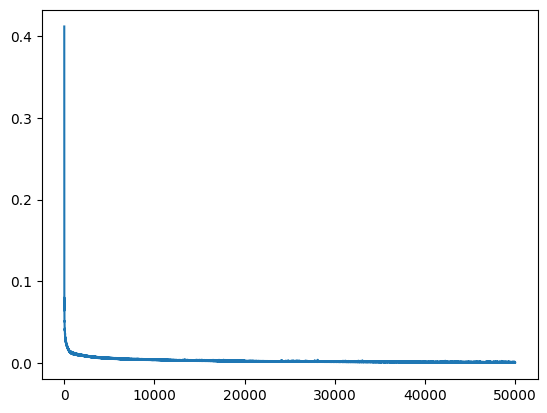

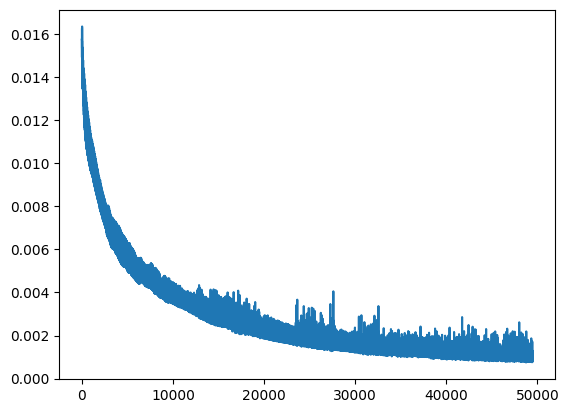

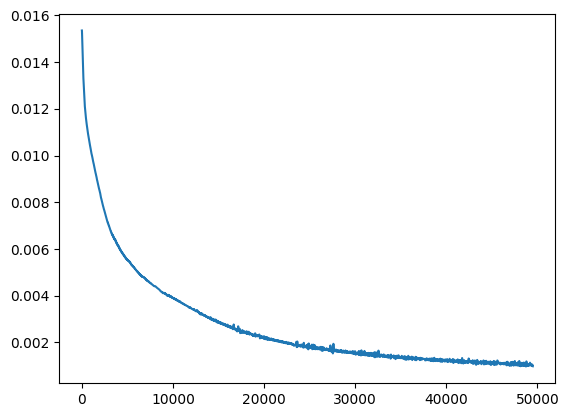

In [29]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

# denoise
latter_training_denoised = gaussian_filter1d(latter_training, sigma=20)
plt.plot(list(range(len(latter_training_denoised))), latter_training_denoised, label='MM')
plt.show()

In [24]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('data/mm.pth'))

In [30]:
# save mm
if not os.path.exists('data/mm.pth'):
    torch.save(mm.state_dict(), 'data/mm.pth')

In [28]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].detach().cpu().numpy()
loss_y = loss[:, 1].detach().cpu().numpy()
loss_theta = (loss[:, 2] + loss[:, 3]).detach().cpu().numpy()

print("training loss", loss.mean().item())

training loss 0.0009943732293322682


In [25]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].detach().cpu().numpy()
loss_y = loss[:, 1].detach().cpu().numpy()
loss_theta = (loss[:, 2] + loss[:, 3]).detach().cpu().numpy()

print("validation loss", loss.mean().item())

validation loss 0.0010110215516760945


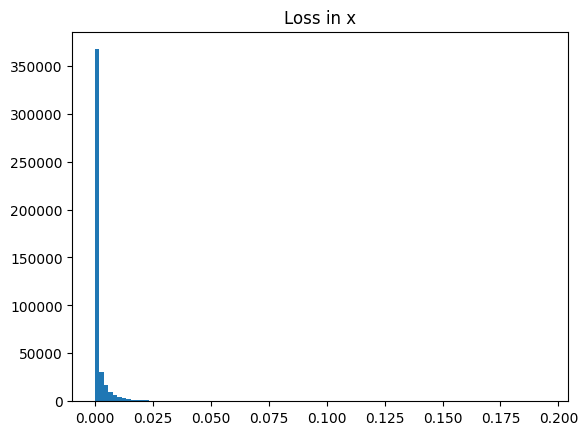

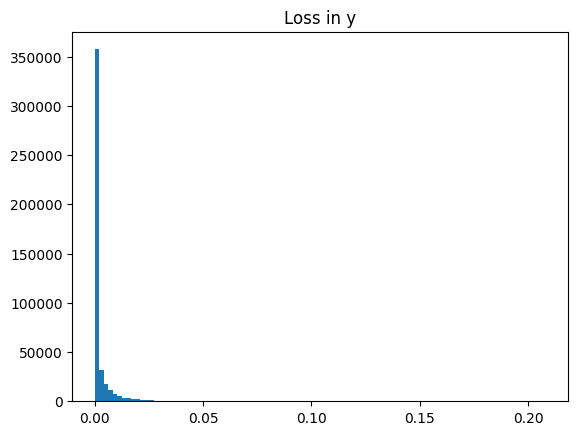

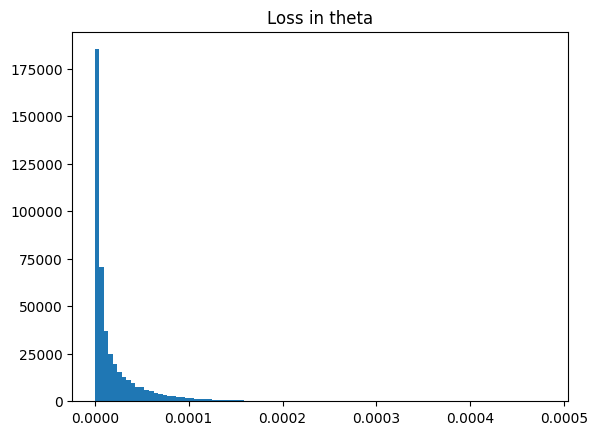

In [29]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()

In [30]:
# identify outliers
outlier_threshold = 0.01

throttles = []
steers = []
speeds = []

# plot outliers
for i, (lx, ly, lt) in enumerate(zip(loss_x, loss_y, loss_theta)):
    if lx > outlier_threshold or ly > outlier_threshold or lt > outlier_threshold:
        throttles.append(a_batch[i][1])
        steers.append(a_batch[i][0])
        speeds.append(np.linalg.norm(s0_batch[i].velocity))

In [31]:
len(throttles)

39115

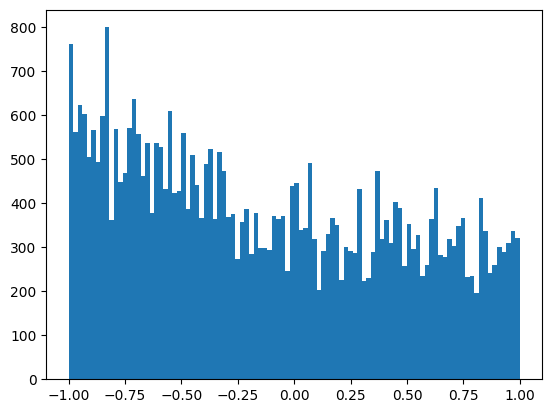

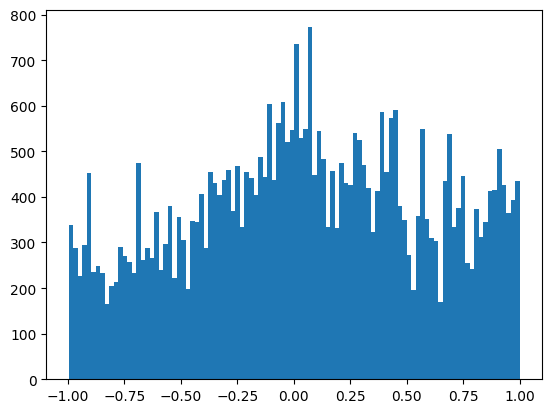

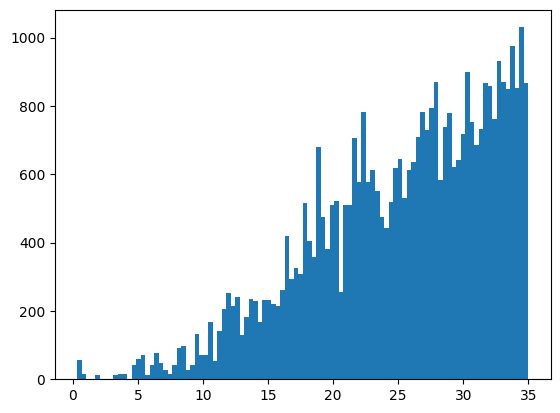

In [32]:
plt.hist(throttles, bins=100)
plt.show()
plt.hist(steers, bins=100)
plt.show()
plt.hist(speeds, bins=100)
plt.show()

In [16]:
throttles_normal = [a[1] for a in a_batch]
steers_normal = [a[0] for a in a_batch]
speeds_normal = [np.linalg.norm(s.velocity) for s in s0_batch]

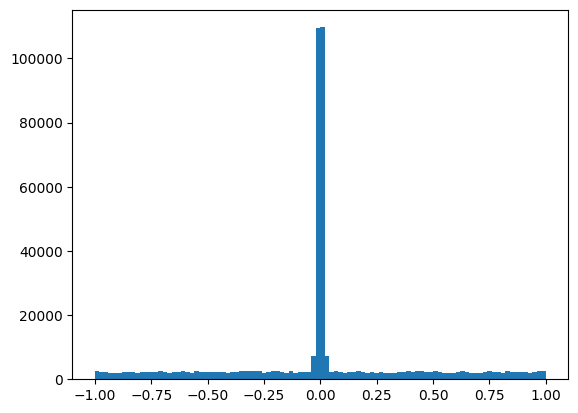

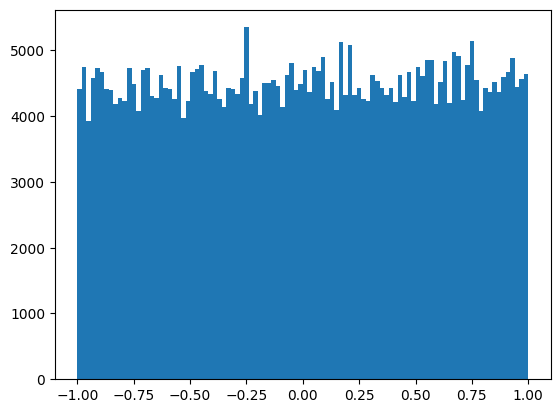

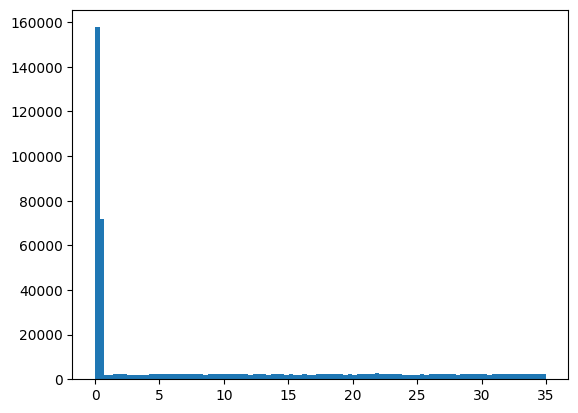

In [20]:
plt.hist(throttles_normal, bins=100)
plt.show()
plt.hist(steers_normal, bins=100)
plt.show()
plt.hist(speeds_normal, bins=100)
plt.show()

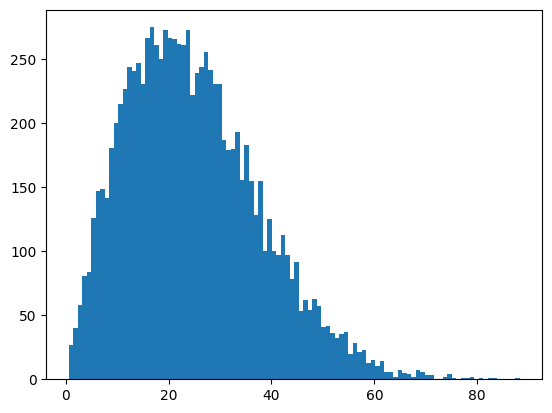

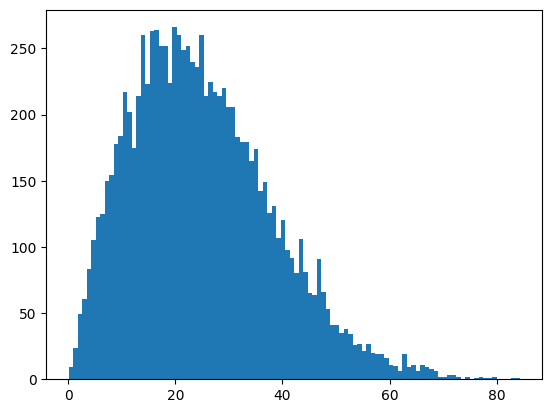

In [21]:
n0_vels = np.stack([np.random.normal(0, 20, 2) for _ in range(10000)])
n1_vels = np.stack([np.random.multivariate_normal([0,0], np.eye(2)*400) for _ in range(10000)])

n0_speeds = np.linalg.norm(n0_vels, axis=1)
n1_speeds = np.linalg.norm(n1_vels, axis=1)

plt.hist(n0_speeds, bins=100)
plt.show()
plt.hist(n1_speeds, bins=100)
plt.show()